# Pipeline completo de classificação com PyTorch

Este notebook implementa um fluxo completo de Machine Learning para um problema de classificação:

1. Carregar o dataset a partir de um arquivo CSV.
2. Visualizar os dados em um gráfico 3D (usando três primeiras features).
3. Verificar o balanceamento das classes com um histograma.
4. Dividir o conjunto de dados em treino, validação e teste.
5. Treinar uma rede neural com validação cruzada (cross-validation) para avaliar a robustez do modelo.
6. Plotar as curvas de treinamento e validação (loss e acurácia) e comparar com o desempenho no teste.
7. Gerar a matriz de confusão para o conjunto de teste.
8. Salvar o modelo treinado e seus pesos em disco.

A ideia é que cada seção seja didática, explicando o porquê de cada passo, e possa ser reutilizada em outros projetos.


In [17]:
# =====================================================
# Instalação de bibliotecas necessárias
# =====================================================

!pip install numpy pandas matplotlib scikit-learn torch torchvision torchaudio ipykernel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Imports básicos
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # necessário para o plot 3D

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Configurações opcionais
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", DEVICE)


Usando dispositivo: cpu


## Carregando o dataset

Nesta etapa vamos:
- Ler o dataset a partir de um arquivo CSV.
- Separar as **features** (entradas) e os **rótulos** (classes).
- Fazer uma inspeção rápida para garantir que os dados foram carregados corretamente.

Assumimos que:
- O arquivo está em `data/dataset.csv`.
- A coluna de rótulo se chama `label`.
- Todas as outras colunas numéricas são usadas como features.


In [19]:
# Caminho para o dataset
DATA_PATH = "dataset_4d_float_0a15.csv"  # ajuste conforme a sua estrutura de pastas

# Carregar o CSV
df = pd.read_csv(DATA_PATH)

print("Primeiras linhas do dataset:")
display(df.head())

print("\nInformações gerais:")
print(df.info())

# Definir coluna de rótulo e features
TARGET_COL = "classe"  
feature_cols = [c for c in df.columns if c != TARGET_COL]

X = df[feature_cols].values.astype(np.float32)
y = df[TARGET_COL].values

n_samples, n_features = X.shape
n_classes = len(np.unique(y))

print(f"\nNúmero de amostras: {n_samples}")
print(f"Número de features: {n_features}")
print(f"Número de classes: {n_classes}")
print("Features:", feature_cols)


Primeiras linhas do dataset:


,x1,x2,x3,x4,classe
0,11.382172,7.362790,11.184214,7.904190,1
1,1.523537,1.758600,4.786270,6.915373,0
2,10.725087,5.610053,10.640465,10.634612,1
3,8.798711,7.849267,6.119261,4.706126,0
4,10.436835,8.684506,7.716666,12.330704,1



Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   x3      2000 non-null   float64
 3   x4      2000 non-null   float64
 4   classe  2000 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 78.3 KB
None

Número de amostras: 2000
Número de features: 4
Número de classes: 2
Features: ['x1', 'x2', 'x3', 'x4']


## Visualização 3D do dataset

Para ter uma intuição inicial sobre a distribuição dos dados, faremos um:

- **Gráfico 3D de dispersão (scatter)** usando as **3 primeiras features** como eixos X, Y e Z.
- As cores dos pontos representarão as diferentes classes.

Isso não substitui uma análise mais profunda, mas ajuda a ter uma percepção visual de possíveis separações entre classes, clusters ou padrões.


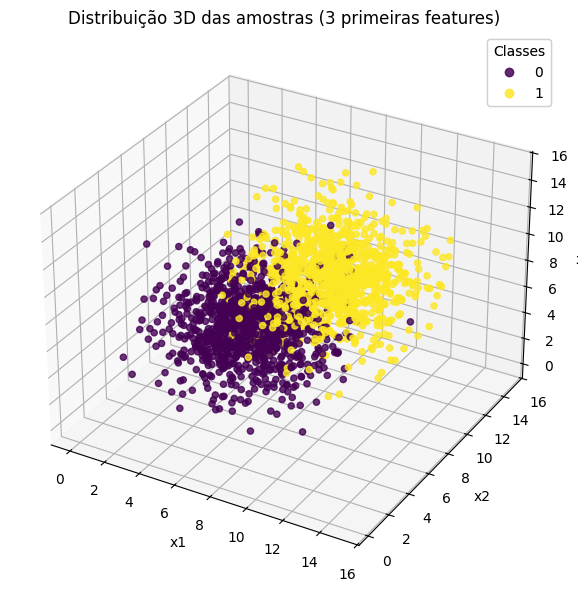

In [20]:
if n_features < 3:
    print("O dataset tem menos de 3 features; não é possível fazer o plot 3D padrão.")
else:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        X[:, 0], X[:, 1], X[:, 2],
        c=y, alpha=0.8
    )

    ax.set_xlabel(feature_cols[0])
    ax.set_ylabel(feature_cols[1])
    ax.set_zlabel(feature_cols[2])
    ax.set_title("Distribuição 3D das amostras (3 primeiras features)")

    # legenda com classes
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

    plt.tight_layout()
    plt.show()


## Histograma das classes (balanceamento)

Antes de treinar o modelo, é importante verificar se o conjunto de dados está **balanceado** entre as classes.

- Um dataset muito desbalanceado pode fazer o modelo "ignorar" classes minoritárias.
- Aqui vamos contar quantas amostras existem em cada classe e visualizar isso em um gráfico de barras.


Contagem de amostras por classe:
0    1000
1    1000
Name: count, dtype: int64


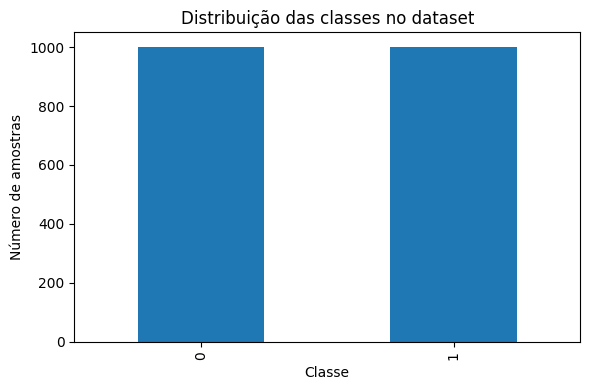

In [21]:
class_counts = pd.Series(y).value_counts().sort_index()

print("Contagem de amostras por classe:")
print(class_counts)

plt.figure(figsize=(6, 4))
class_counts.plot(kind="bar")
plt.xlabel("Classe")
plt.ylabel("Número de amostras")
plt.title("Distribuição das classes no dataset")
plt.tight_layout()
plt.show()


## Divisão em treino, validação e teste

Para avaliar corretamente o modelo, dividimos o dataset em:

- **Treino (train)**: usado para ajustar os pesos do modelo.
- **Validação (validation)**: usado durante o treinamento (e na cross-validation) para monitorar overfitting e ajustar hiperparâmetros.
- **Teste (test)**: mantido "escondido" até o final, para estimar o desempenho real do modelo em dados novos.

Usaremos uma divisão estratificada, mantendo a proporção de classes em cada subconjunto.
Um exemplo comum é:

- 60% treino
- 20% validação
- 20% teste


In [22]:
# Primeiro separamos TESTE (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

# Depois separamos TREINO (60%) e VALIDAÇÃO (20%) a partir do restante (80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25,  # 0.25 de 0.8 = 0.2 do total
    stratify=y_temp, random_state=RANDOM_SEED
)

print("Tamanhos:")
print("Treino:", X_train.shape[0])
print("Validação:", X_val.shape[0])
print("Teste:", X_test.shape[0])


Tamanhos:
Treino: 1200
Validação: 400
Teste: 400


## Preparando Dataset e DataLoaders (PyTorch)

Para treinar com PyTorch, é conveniente:

- Criar uma classe `Dataset` que devolve (features, label) em formato de tensor.
- Criar `DataLoader`s para **treino**, **validação** e **teste**, que:
  - embaralham os dados (no caso de treino),
  - cuidam do batch size,
  - facilitam o loop de treinamento.

Isso deixa o código mais organizado e reutilizável.


In [23]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


BATCH_SIZE = 32

train_dataset = TabularDataset(X_train, y_train)
val_dataset   = TabularDataset(X_val,   y_val)
test_dataset  = TabularDataset(X_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)


(38, 13, 13)

## Definição do modelo (MLP) e validação cruzada

Vamos usar uma **rede neural totalmente conectada (MLP)** simples:

- Entrada: `n_features` (dimensão do vetor de entrada).
- Camadas ocultas com função de ativação ReLU.
- Saída: `n_classes` neurônios, usando `CrossEntropyLoss`.

Também vamos implementar **validação cruzada (StratifiedKFold)** em cima do conjunto de treino+validação, para:
- Estimar melhor a generalização do modelo.
- Obter curvas médias de loss e acurácia de treino/validação ao longo das épocas.

Depois, treinaremos um modelo final em `X_train` + `X_val` e avaliaremos em `X_test`.


## Obs: Ajustar o número de neurônios em cada camada conforme seu grupo


In [24]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        # saída com 1 neurônio (classificação binária)
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # saída [batch, 1] com logits (sem sigmoid aqui)
        return self.net(x)


def train_one_epoch(model, optimizer, criterion, data_loader):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(DEVICE)
        # y em {0,1}; precisa ser float e shape [batch, 1] para BCEWithLogitsLoss
        y_batch = y_batch.to(DEVICE).float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(X_batch)              # [batch, 1] logits
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

        # previsão: sigmoid + limiar 0.5
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long().view(-1)      # [batch]
        y_true = y_batch.long().view(-1)           # [batch]

        running_correct += (preds == y_true).sum().item()
        total += X_batch.size(0)

    return running_loss / total, running_correct / total


def evaluate(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE).float().view(-1, 1)

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            running_loss += loss.item() * X_batch.size(0)

            probs = torch.sigmoid(outputs)
            preds = (probs >= 0.5).long().view(-1)
            y_true = y_batch.long().view(-1)

            running_correct += (preds == y_true).sum().item()
            total += X_batch.size(0)

    return running_loss / total, running_correct / total


def cross_validate_mlp(X, y, n_splits=5, n_epochs=30, hidden_dims=[2], lr=1e-3):
    """
    Faz K-fold cross-validation em X, y (numpy arrays) para classificação binária.
    Arquitetura fixa: input_dim -> 5 -> 3 -> 1.
    Retorna histórico médio de treino/validação por época.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # Históricos acumulados
    all_train_loss = []
    all_val_loss   = []
    all_train_acc  = []
    all_val_acc    = []

    input_dim = X.shape[1]

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n=== Fold {fold}/{n_splits} ===")

        X_tr, X_vl = X[train_idx], X[val_idx]
        y_tr, y_vl = y[train_idx], y[val_idx]

        train_ds = TabularDataset(X_tr, y_tr)
        val_ds   = TabularDataset(X_vl, y_vl)

        train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

        model = MLPClassifier(input_dim, hidden_dims).to(DEVICE)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        fold_train_loss = []
        fold_val_loss   = []
        fold_train_acc  = []
        fold_val_acc    = []

        for epoch in range(1, n_epochs + 1):
            train_loss, train_acc = train_one_epoch(model, optimizer, criterion, train_dl)
            val_loss, val_acc     = evaluate(model, criterion, val_dl)

            fold_train_loss.append(train_loss)
            fold_val_loss.append(val_loss)
            fold_train_acc.append(train_acc)
            fold_val_acc.append(val_acc)

            print(
                f"Época {epoch}/{n_epochs} | "
                f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
            )

        all_train_loss.append(fold_train_loss)
        all_val_loss.append(fold_val_loss)
        all_train_acc.append(fold_train_acc)
        all_val_acc.append(fold_val_acc)

    # Converter para numpy e tirar média por época
    mean_train_loss = np.mean(np.array(all_train_loss), axis=0)
    mean_val_loss   = np.mean(np.array(all_val_loss),   axis=0)
    mean_train_acc  = np.mean(np.array(all_train_acc),  axis=0)
    mean_val_acc    = np.mean(np.array(all_val_acc),    axis=0)

    history = {
        "train_loss": mean_train_loss,
        "val_loss":   mean_val_loss,
        "train_acc":  mean_train_acc,
        "val_acc":    mean_val_acc,
    }

    return history


## Treinando com cross-validation e analisando as curvas

Agora vamos:

1. Rodar a **validação cruzada (K-fold)** usando o conjunto de treino+validação (`X_temp`, `y_temp`).
2. Coletar o histórico médio de:
   - Loss de treino
   - Loss de validação
   - Acurácia de treino
   - Acurácia de validação
3. Plotar essas curvas para observar:
   - Convergência do modelo
   - Possíveis sinais de overfitting (por exemplo, loss de validação subindo enquanto a de treino desce).

Depois disso, treinaremos um modelo final com `X_train + X_val` e avaliaremos em `X_test`.


## Obs: Ajustar o número de neurônios em cada camada conforme seu grupo


In [25]:
# Dataset e DataLoader para treino+val (treino final usando X_temp, y_temp)
final_train_dataset = TabularDataset(X_temp, y_temp)
final_train_loader  = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Definir modelo final
input_dim   = X.shape[1]      # número de features de entrada (no teu caso, 4)
hidden_dims = [2]          # 1ª camada: 5 neurônios, 2ª camada: 3 neurônios

final_model = MLPClassifier(input_dim, hidden_dims).to(DEVICE)

# Como a saída tem 1 neurônio (binário), usamos BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-3)

N_EPOCHS_FINAL = 70

final_train_loss_hist = []
final_train_acc_hist  = []
final_val_loss_hist   = []
final_val_acc_hist    = []

for epoch in range(1, N_EPOCHS_FINAL + 1):
    train_loss, train_acc = train_one_epoch(final_model, optimizer, criterion, final_train_loader)
    val_loss, val_acc     = evaluate(final_model, criterion, val_loader)  # usando val_loader separado

    final_train_loss_hist.append(train_loss)
    final_train_acc_hist.append(train_acc)
    final_val_loss_hist.append(val_loss)
    final_val_acc_hist.append(val_acc)

    print(
        f"Época {epoch}/{N_EPOCHS_FINAL} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
    )

# Avaliação no conjunto de teste
test_loss, test_acc = evaluate(final_model, criterion, test_loader)
print(f"\nDesempenho no conjunto de TESTE -> Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")


Época 1/70 | Train Loss: 2.2690, Acc: 0.5000 | Val Loss: 2.0056, Acc: 0.5000
Época 2/70 | Train Loss: 1.7765, Acc: 0.5000 | Val Loss: 1.5661, Acc: 0.5000
Época 3/70 | Train Loss: 1.3874, Acc: 0.5000 | Val Loss: 1.2292, Acc: 0.5000
Época 4/70 | Train Loss: 1.1049, Acc: 0.5000 | Val Loss: 0.9975, Acc: 0.5000
Época 5/70 | Train Loss: 0.9206, Acc: 0.5000 | Val Loss: 0.8580, Acc: 0.5000
Época 6/70 | Train Loss: 0.8160, Acc: 0.5000 | Val Loss: 0.7832, Acc: 0.5000
Época 7/70 | Train Loss: 0.7639, Acc: 0.5000 | Val Loss: 0.7479, Acc: 0.5000
Época 8/70 | Train Loss: 0.7393, Acc: 0.5000 | Val Loss: 0.7317, Acc: 0.5000
Época 9/70 | Train Loss: 0.7276, Acc: 0.5000 | Val Loss: 0.7232, Acc: 0.5000
Época 10/70 | Train Loss: 0.7208, Acc: 0.5000 | Val Loss: 0.7177, Acc: 0.5000
Época 11/70 | Train Loss: 0.7160, Acc: 0.5000 | Val Loss: 0.7141, Acc: 0.5000
Época 12/70 | Train Loss: 0.7126, Acc: 0.5000 | Val Loss: 0.7111, Acc: 0.5000
Época 13/70 | Train Loss: 0.7099, Acc: 0.5000 | Val Loss: 0.7082, Acc: 0.

## Treinamento final e avaliação no conjunto de teste

Após verificar que o modelo converge bem na validação cruzada, treinamos um **modelo final** usando:

- Conjunto de **treino + validação** (`X_temp`, `y_temp`) para aproveitar mais dados.
- Hiperparâmetros definidos anteriormente (ex.: número de épocas, taxa de aprendizado, arquitetura).

Em seguida, avaliamos o modelo final no **conjunto de teste**, que ficou completamente separado, obtendo:

- Loss de teste
- Acurácia de teste

Isso fornece uma estimativa mais honesta do desempenho em dados novos.



## Obs: Ajustar o número de neurônios em cada camada conforme seu grupo


In [26]:
# Dataset e DataLoader para treino+val (treino final usando X_temp, y_temp)
final_train_dataset = TabularDataset(X_temp, y_temp)
final_train_loader  = DataLoader(final_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Definir modelo final
input_dim   = X.shape[1]      # número de features de entrada (no teu caso, 4)
hidden_dims = [2]          # 1ª camada: 5 neurônios, 2ª camada: 3 neurônios

final_model = MLPClassifier(input_dim, hidden_dims).to(DEVICE)

# Como a saída tem 1 neurônio (binário), usamos BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-3)

N_EPOCHS_FINAL = 70

final_train_loss_hist = []
final_train_acc_hist  = []
final_val_loss_hist   = []
final_val_acc_hist    = []

for epoch in range(1, N_EPOCHS_FINAL + 1):
    train_loss, train_acc = train_one_epoch(final_model, optimizer, criterion, final_train_loader)
    val_loss, val_acc     = evaluate(final_model, criterion, val_loader)  # usando val_loader separado

    final_train_loss_hist.append(train_loss)
    final_train_acc_hist.append(train_acc)
    final_val_loss_hist.append(val_loss)
    final_val_acc_hist.append(val_acc)

    print(
        f"Época {epoch}/{N_EPOCHS_FINAL} | "
        f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}"
    )

# Avaliação no conjunto de teste
test_loss, test_acc = evaluate(final_model, criterion, test_loader)
print(f"\nDesempenho no conjunto de TESTE -> Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")


Época 1/70 | Train Loss: 0.8084, Acc: 0.4256 | Val Loss: 0.7385, Acc: 0.4425
Época 2/70 | Train Loss: 0.7215, Acc: 0.4756 | Val Loss: 0.7088, Acc: 0.4975
Época 3/70 | Train Loss: 0.7063, Acc: 0.5094 | Val Loss: 0.7022, Acc: 0.5300
Época 4/70 | Train Loss: 0.7001, Acc: 0.5212 | Val Loss: 0.6971, Acc: 0.5300
Época 5/70 | Train Loss: 0.6950, Acc: 0.5331 | Val Loss: 0.6934, Acc: 0.5350
Época 6/70 | Train Loss: 0.6914, Acc: 0.5369 | Val Loss: 0.6900, Acc: 0.5400
Época 7/70 | Train Loss: 0.6878, Acc: 0.5463 | Val Loss: 0.6869, Acc: 0.5500
Época 8/70 | Train Loss: 0.6851, Acc: 0.5500 | Val Loss: 0.6841, Acc: 0.5600
Época 9/70 | Train Loss: 0.6822, Acc: 0.5600 | Val Loss: 0.6815, Acc: 0.5700
Época 10/70 | Train Loss: 0.6794, Acc: 0.5681 | Val Loss: 0.6790, Acc: 0.5750
Época 11/70 | Train Loss: 0.6776, Acc: 0.5725 | Val Loss: 0.6767, Acc: 0.5750
Época 12/70 | Train Loss: 0.6748, Acc: 0.5800 | Val Loss: 0.6745, Acc: 0.5875
Época 13/70 | Train Loss: 0.6725, Acc: 0.5813 | Val Loss: 0.6722, Acc: 0.

## Curvas de treinamento, validação e ponto de teste

Agora vamos:

- Plotar as curvas de **loss** e **acurácia** para:
  - Treino
  - Validação

- Indicar o **resultado final no teste** como uma referência (por exemplo, uma linha horizontal ou anotação no gráfico).

Isso ajuda a comparar:
- Como o modelo se comporta durante o treinamento (treino x validação).
- Se o desempenho em teste está coerente com os resultados de validação.


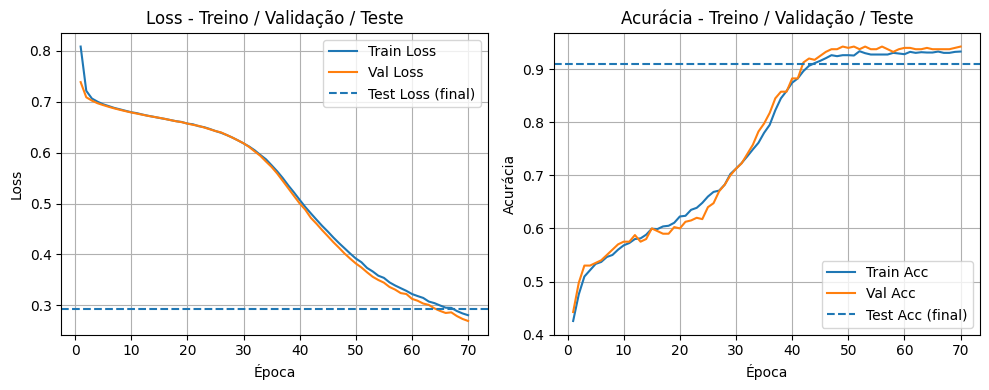

In [27]:
epochs_final = np.arange(1, N_EPOCHS_FINAL + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_final, final_train_loss_hist, label="Train Loss")
plt.plot(epochs_final, final_val_loss_hist,   label="Val Loss")
plt.axhline(y=test_loss, linestyle="--", label="Test Loss (final)")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Loss - Treino / Validação / Teste")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_final, final_train_acc_hist, label="Train Acc")
plt.plot(epochs_final, final_val_acc_hist,   label="Val Acc")
plt.axhline(y=test_acc, linestyle="--", label="Test Acc (final)")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Acurácia - Treino / Validação / Teste")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Matriz de confusão no conjunto de teste

A **matriz de confusão** mostra, para cada classe:

- Quantas amostras foram classificadas corretamente.
- Para quais classes ocorreram erros de classificação.

Ela é uma ferramenta muito útil para entender *em que tipo de erro o modelo está cometendo* e se existe alguma classe mais problemática.


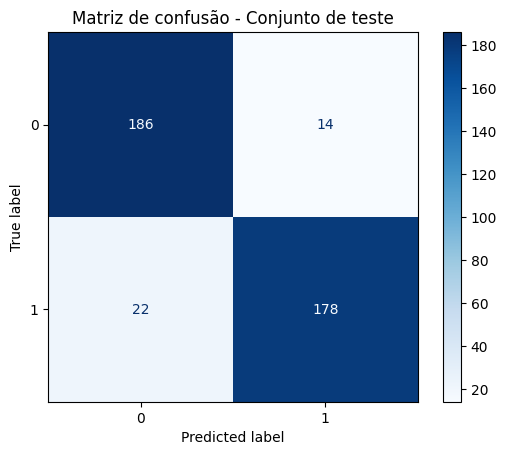

Acurácia no teste: 0.91


In [28]:
# Coletar previsões no conjunto de teste
final_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(DEVICE)
        # y_batch vem como long (0 ou 1) do Dataset
        y_batch = y_batch.to(DEVICE).float().view(-1, 1)

        logits = final_model(X_batch)          # [batch, 1]
        probs  = torch.sigmoid(logits)         # [batch, 1] em [0,1]
        preds  = (probs >= 0.5).long().view(-1)   # [batch] 0 ou 1
        y_true_batch = y_batch.long().view(-1)    # [batch] 0 ou 1

        y_true.extend(y_true_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de confusão - Conjunto de teste")
plt.show()

print("Acurácia no teste:", accuracy_score(y_true, y_pred))


## Salvando o modelo e os pesos

Finalmente, vamos salvar:

- Os **pesos** do modelo (`state_dict`) em um arquivo `.pth`.
- Opcionalmente, o **modelo completo** (estrutura + pesos) para facilitar o carregamento futuro.

Isso permite:
- Reutilizar o modelo em produção.
- Carregá-lo em outro notebook/script sem precisar treinar de novo.


In [29]:
OUTPUT_DIR = "modelos"
os.makedirs(OUTPUT_DIR, exist_ok=True)

weights_path = os.path.join(OUTPUT_DIR, "mlp_pesos.pth")
model_path   = os.path.join(OUTPUT_DIR, "mlp_modelo_completo.pth")

# Salvar apenas os pesos
torch.save(final_model.state_dict(), weights_path)

# Salvar o modelo completo (estrutura + pesos)
torch.save(final_model, model_path)

print("Pesos salvos em:", weights_path)
print("Modelo completo salvo em:", model_path)


Pesos salvos em: modelos\mlp_pesos.pth
Modelo completo salvo em: modelos\mlp_modelo_completo.pth


In [31]:
import numpy as np
import torch.nn as nn

def export_weights_human_readable(model, output_dir="modelos", base_name="mlp_weights_human"):
    os.makedirs(output_dir, exist_ok=True)

    linhas_txt = []
    layer_id = 0

    for module in model.net:
        if isinstance(module, nn.Linear):
            W = module.weight.detach().cpu().numpy()  # shape: [out_features, in_features]
            b = module.bias.detach().cpu().numpy()    # shape: [out_features]

            linhas_txt.append(
                f"Layer {layer_id} (Linear)  in_features={module.in_features}  out_features={module.out_features}"
            )

            # Salva também em CSV por camada, se quiser
            csv_w_path = os.path.join(output_dir, f"layer{layer_id}_weights.csv")
            csv_b_path = os.path.join(output_dir, f"layer{layer_id}_bias.csv")
            np.savetxt(csv_w_path, W, delimiter=",")
            np.savetxt(csv_b_path, b.reshape(1, -1), delimiter=",")

            for neuron_idx in range(module.out_features):
                pesos_neuronio = W[neuron_idx]  # todos os pesos que chegam nesse neurônio
                bias_neuronio = b[neuron_idx]

                pesos_str = ", ".join(f"{w:.6f}" for w in pesos_neuronio)
                linhas_txt.append(
                    f"  neurônio {neuron_idx}: weights = [{pesos_str}], bias = {bias_neuronio:.6f}"
                )

            linhas_txt.append("")  # linha em branco entre camadas
            layer_id += 1

    txt_path = os.path.join(output_dir, base_name + ".txt")
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write("\n".join(linhas_txt))

    print("Arquivo texto com pesos salvo em:", txt_path)
    print("Arquivos CSV por camada salvos em:", output_dir)


# Chamar a função para o modelo final treinado
export_weights_human_readable(final_model, output_dir="modelos", base_name="mlp_weights_for_fpga")


Arquivo texto com pesos salvo em: modelos\mlp_weights_for_fpga.txt
Arquivos CSV por camada salvos em: modelos
